<a href="https://colab.research.google.com/github/hamza0011/Scraping-TripAdvisor-with-Python-2020/blob/master/Copy_of_Homework_5_Student_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 545 Homework 5: Deep Learning with MXNet

Welcome to CIS 545 Homework 5! 

In this homework, we will learn more about the "new electricity" - Deep Learning (we didn't coin this term, Andrew Ng did)! There are many cool frameworks for building deep learning models:  PyTorch, Tensorflow, Theano, MxNet. Since you will be working with Big Data in this course, you need a framework that scales well. Almost all of these have multi-GPU support built in; MxNet provides the easiest abstractions to do this and works well with AWS as well as Colab. In this assignment, we will be building neural networks in MxNet to solve an interesting problem.

Deep learning or neural network architectures have been used to solve a multitude of problems in various different fields like vision, natural language processing, and radiology. So let's take a "deep" dive into them!

![alt text](http://4.bp.blogspot.com/-sLgBLS3bJO8/U__Kx6PnkRI/AAAAAAAAAWM/Gz3cL5jiwTo/s320/godeeper.jpg)


**Note**:  If possible you should run this notebook in Colab, with a GPU.  This should be set by default (see Runtime|Change Runtime Type).  If Colab gives an error that no machines with GPUs are available, you can go the File|Download|Download .ipynb; then launch AWS SageMaker Notebook as per the last section in the AWS Getting Started Guide; then upload the notebook to SageMaker Notebook and work there.




## Why deep learning? 


*   It's coooool
*   Everyone is talking about is these days, People like Siraj Raval can teach it in 5 mins (Check out his youtube channel for some comedy)
*    Deep learning unlocks the treasure trove of unstructured big data for those with the imagination to use it
*   Deep learning models have great representational power and are 'universal approximators'


### Deep Learning Applications:


Deep learning has been significantly improved voice command systems (such as Siri and Alexa), as well as healthcare and image identification.

Deep learning has applications across numerous industries, which is why experts think that this technology is the future of almost everything. There are truly deep learning technologies such as Google’s very human-like talking AI, a new theory that cracks the 'black box' of deep learning, and various budding ideas like this one about why human forgetting might be the key to AI. Here are some cool applications of deep learning - 

Here's a neural network detecting anomalies in Chest Xrays :




![alt text](https://imgur.com/HKPzrzP.jpg)

Most humans can't tell that this is a case of Pleural Effusion {sounds like medical jargon to engineers like us} but this Neural Network model can detect it very well!

Mask RCNNs in action for detecting objects on the road aiding a self driving vehicle's driving: 
![alt text](https://miro.medium.com/max/3864/1*O4wsvh0CHWjP6IrK9HI_Zg.png)

Pretty cool, right? We will be appling CNNs to solve a cool image classification problem.


# Setup Skeleton



## Penn Grader Setup
Make sure to initialize the grader with your 8 digit Penn ID.

In [1]:
%%capture
!pip3 install penngrader
from penngrader.grader import *

VERY IMPORTANT : Enter your **8 digit Penn ID** in the student id field below

PLEASE NOTE: There are some questions, for example making plots, that do not have test cases. All questions without an autograder attached will be manually graded. 

In [2]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO 
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID =  99999999# YOUR PENN-ID GOES HERE AS AN INTEGER#

In [3]:
grader = PennGrader(homework_id = 'CIS545_MCITO_Fall_2021_HW5', student_id = STUDENT_ID)

PennGrader initialized with Student ID: 99999999

Make sure this correct or we will not be able to store your grade


## MxNet Installation

First, verify that you see a Tesla or other GPU listed here...

In [4]:
!nvidia-smi

Mon Nov 22 18:21:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
%%capture
!pip3 install --upgrade mxnet-cu101 gluoncv

In [6]:
import mxnet as mx
from gluoncv.utils import viz
from mxnet.gluon.data import DataLoader
from mxnet.gluon.data.vision import transforms
from mxnet import np
import shutil

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.10.0+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [7]:
from mxnet import np, npx
from mxnet.gluon import nn
npx.set_np()

if npx.num_gpus() < 1:
  raise "No GPU is found, please restart your runtime!"

# Section 1 : Indoor Scene Recognition with MXNet
## 1.1 Lots of Data

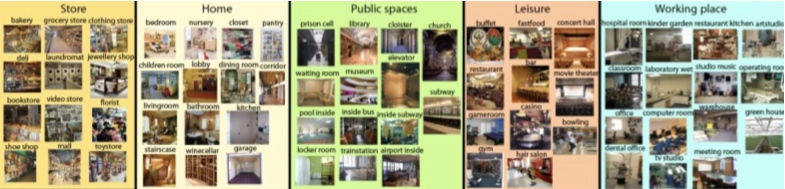

The datset we use is used for the indoor scene recognition problem. Indoor scene recognition is a challenging open problem in high level vision. Most scene recognition models that work well for outdoor scenes perform poorly in the indoor domain. The main difficulty is that while some indoor scenes (e.g. corridors) can be well characterized by global spatial properties, others (e.g., bookstores) are better characterized by the objects they contain. More generally, to address the indoor scenes recognition problem we need a model that can exploit local and global discriminative information.
 
The dataset contains 67 Indoor categories. The number of images varies across categories, but there are at least 100 images per category. All images are in jpg format. 

## Download the dataset
Run the cell below to download the dataset from Google Drive.

In [8]:
!wget -nc https://storage.googleapis.com/penn-cis545/data.zip

import os
from google.colab import drive
from google_drive_downloader import GoogleDriveDownloader as gdd


# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS545_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS545_2020')
HOMEWORK_FOLDER=os.path.join(CIS545_FOLDER, 'HW5')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)


gdd.download_file_from_google_drive(file_id='1A-dYo1ba1mjTrnH6xjzYrg_fO_GxHjvN', dest_path='/content/gdrive/My Drive/CIS545_2020/HW5/data.zip')

!unzip -nq "data.zip"

File ‘data.zip’ already there; not retrieving.

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 1.1.1 Filter out corrupt and nonexistent images (5 points)

There are a lot of images in the dataset that aren't valid JPEG images. We need to filter out the invalid images! Complete the check_corrupt function which takes in a filename and returns a boolean indicating if the file is valid. Hint: the PIL library would be useful for this verification!




In [9]:
import os
from PIL import Image

base_path = 'indoorCVPR_09/Images'
train_path = os.path.join(base_path, 'train/')
test_path = os.path.join(base_path,'test/')
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)


def check_corrupt(filename):
    #TODO -- also fix the return result!
    im = Image.open(filename)
    if im.mode != 'P':
      try:
        im.verify()
        return False
      except Exception:
        return True
    if im.mode == 'P':
      return True
    

# Check all images in the train file for validity and write the valid ones to train_path
with open("TrainImages.txt", "r") as train_file:
  correct_file_count_train = 0
  for file in train_file:
      image_path = os.path.join(base_path,file.rstrip('\n'))
      dest_folder = os.path.join(train_path, file.split('/')[0])
      os.makedirs(dest_folder, exist_ok=True)
      dest_path = os.path.join(train_path,file.rstrip('\n'))
      if os.path.getsize(image_path) == 0 or check_corrupt(image_path):
          continue
      correct_file_count_train += 1
      dest = shutil.move(image_path, dest_path)  

correct_file_count_test = 0
with open("TestImages.txt", "r") as test_file:
  for file in test_file:
      image_path = os.path.join(base_path,file.rstrip('\n'))
      dest_folder = os.path.join(test_path, file.split('/')[0])
      os.makedirs(dest_folder, exist_ok=True)
      dest_path = os.path.join(test_path,file.rstrip('\n'))
      if os.path.getsize(image_path) == 0 or check_corrupt(image_path):
          continue
      correct_file_count_test += 1
      dest = shutil.move(image_path, dest_path)  

In [10]:
grader.grade('check_file_cleaning', (correct_file_count_train, correct_file_count_test))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 1.1.2 Build a dataset class (5 points)

Create train and test datasets for loading image files stored in a folder structure within train_path and test_path. Make sure that the image pixels  are `float`s in the range `[0,1]` and not `int`egers between `[0,255]` (Hint: transform parameter)

Name your datasets `train_dataset` and `test_dataset`.

Read about how you can do it [here](https://mxnet.apache.org/versions/1.7.0/api/python/docs/tutorials/packages/gluon/data/datasets.html#Machine-learning-with-Datasets-and-DataLoaders).


In [11]:
# TODO: Create train_dataset and test_dataset
train_dataset = mx.gluon.data.vision.datasets.ImageFolderDataset(train_path, flag=1, transform= lambda data, label: (data.astype(np.float32)/255, label) )
test_dataset = mx.gluon.data.vision.datasets.ImageFolderDataset(test_path, flag=1, transform= lambda data, label: (data.astype(np.float32)/255, label) )

In [12]:
sample_train_img, sample_train_label = train_dataset[5]
sample_test_img, sample_test_label = test_dataset[5]
sample_train_img = sample_train_img.asnumpy()
sample_train_label = sample_train_label
sample_test_img = sample_test_img.asnumpy()
sample_test_label = sample_test_label

grader.grade('check_datasets', [sample_train_img,sample_train_label, sample_test_img, sample_test_label])

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 1.1.3 Visualize images from the dataset

We have our training and testing datasets but we humans don't really understand binary that well. So let's visualize what our data is by plotting some data points


![alt text](https://www.pathinteractive.com/wp-content/uploads/2018/01/data-mining-img-2-3.jpg)

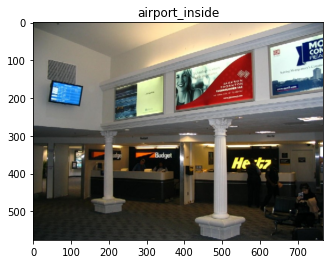

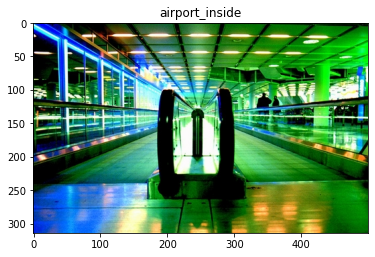

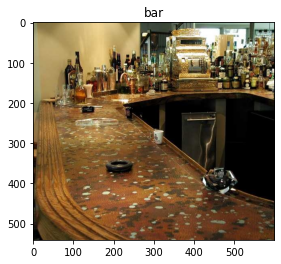

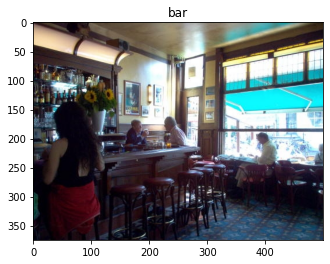

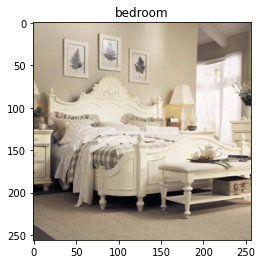

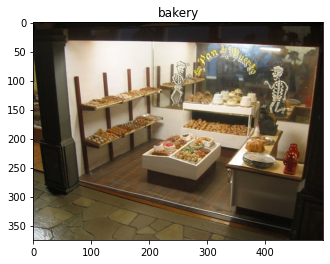

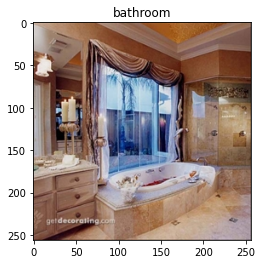

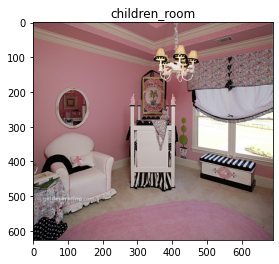

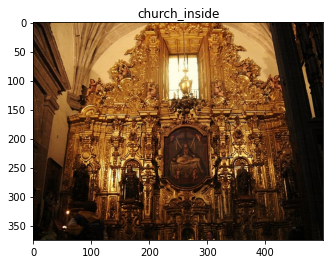

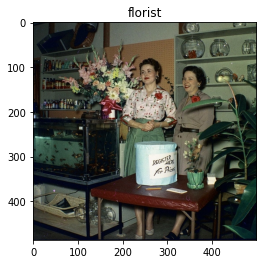

In [13]:
# Visualize 10 images in the dataset with their labels
%matplotlib inline

import matplotlib.pyplot as plt

sample_idxs = [4, 5, 345, 356, 492, 316, 423, 894, 1024, 2048]
for sample_idx in sample_idxs:
    data, label = train_dataset[sample_idx]
    plt.imshow(data.asnumpy())
    plt.title(train_dataset.synsets[label])
    plt.show()


We can see that these images are all different sizes and some examples can be really hard to classify - like the airport inside class!

## 1.1.4 Class frequency distributions (5 points)
Create a frequency distribution of the classes in the training dataset. We're going to do this with a *dataset loader* which iterates through the dataset items in batches. (We need to do this or else we'll run out of RAM trying to load everything!)

Within `create_frequency_dict` you should iterate over the batches (already done) and then the items in a batch.

You should create a dictionary with the number of faces belonging to each of the emotions. The key for the dictionary should be the name of the scene and the value should be the frequency in the train dataset.

In [13]:
def create_frequency_dict(train_dataset):
    scene_frequency_dict = {}
    #TODO: Create the scene frequency distribution
    for i in range(len(train_dataset)):
        label = train_dataset.synsets[train_dataset[i][1]]
        if label not in scene_frequency_dict.keys():
          scene_frequency_dict.update({label: 0})
        scene_frequency_dict[label] = scene_frequency_dict[label]+1
    return scene_frequency_dict
scene_frequency_dict = create_frequency_dict(train_dataset)
print(scene_frequency_dict)                        


{'airport_inside': 80, 'artstudio': 80, 'auditorium': 82, 'bakery': 81, 'bar': 82, 'bathroom': 82, 'bedroom': 79, 'bookstore': 80, 'bowling': 80, 'buffet': 79, 'casino': 81, 'children_room': 82, 'church_inside': 81, 'classroom': 82, 'cloister': 80, 'closet': 81, 'clothingstore': 82, 'computerroom': 80, 'concert_hall': 80, 'corridor': 79, 'deli': 81, 'dentaloffice': 79, 'dining_room': 82, 'elevator': 79, 'fastfood_restaurant': 80, 'florist': 81, 'gameroom': 80, 'garage': 81, 'greenhouse': 80, 'grocerystore': 79, 'gym': 82, 'hairsalon': 79, 'hospitalroom': 80, 'inside_bus': 77, 'inside_subway': 79, 'jewelleryshop': 78, 'kindergarden': 80, 'kitchen': 79, 'laboratorywet': 78, 'laundromat': 78, 'library': 79, 'livingroom': 80, 'lobby': 80, 'locker_room': 79, 'mall': 80, 'meeting_room': 78, 'movietheater': 80, 'museum': 77, 'nursery': 80, 'office': 79, 'operating_room': 81, 'pantry': 80, 'poolinside': 79, 'prisoncell': 80, 'restaurant': 80, 'restaurant_kitchen': 77, 'shoeshop': 81, 'stairsca

In [14]:
grader.grade('check_freq_dists', scene_frequency_dict)

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Does the class distribution look uniform? If yes, we don't need to address class imbalance, if no, what should we do?

## 1.1.5 Create Dataloader objects (5 points)


Data loaders create data batches and perform transformations on the images. 

Since the images are different sizes, we need to resize them to the same value. You should write a `transform`ation to resize the image to 224 x 224. You would also need to add a transformation to convert the image to a *tensor* -- one of the building blocks of neural network operations. Tensors are like numpy arrays with a gradient aspect. 

TLDR, in this section you will need to:
 
*   Define a composition of transformations to first resize the image and then convert to tensors
*   Next create train and test data loaders, apply the transformations to the train and test datasets respectively. You will also need to pass in the batch size and whether or not you want to shuffle the data. 

Set `shuffle = True` for the train and `False` for the test set. 
* Use a batch size of 32 for the training loader.
* Use a batch size of 1 for the test set.

[Refer to](https://mxnet.apache.org/api/python/docs/api/gluon/data/vision/transforms/index.html#mxnet.gluon.data.vision.transforms.Compose) to the transformation documentation


In [15]:
from mxnet.gluon.data.vision import transforms

# TODO: Define the transformation and the train and test loaders
transformer = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])
train_dataset = train_dataset.transform_first(transformer)
test_dataset = test_dataset.transform_first(transformer)
train_loader = mx.gluon.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = mx.gluon.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [16]:
answer = None
for data, label in train_loader:
    answer = data.asnumpy().shape, label.asnumpy().shape
    break

answer2 = None
for data, label in test_loader:
    answer2 = data.asnumpy(), label.asnumpy()
    break


grader.grade('check_loaders', (answer, answer2))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Section 2: Let's build classifiers!

We have the data we need to train a scene classifier. We will start simple with a logistic regression classifier as a baseline for our performance before we move onto more complex neural networks. 

## 2.1.1 Logical Logistic Regression - Baseline (25 points)

 Let's first try solving this problem with a Logistic Regression classifier solving the multiclass classification problem.

We will define a logistic regression model in Apache MxNet and train it on our training set and evaluate the performance on the test set.

*Note*: With MxNet, data (tensors) are typically in `ndarrays`.  However, certain functions expect Numpy arrays.  Occasionally you'll get an error when you pass an array into a function, where it tells you to call `as_np_ndarray()` or `as_nd_ndarray()`.  If you get that error, just follow the instructions and you should be fine.


### Model Definition

We will define our first model in mxnet. In the MXNet/Gluon docs, read up about the `gluon` and `autograd` modules and how to use them to create layers in a neural network.

Our first model is a logistic regression model with the number of outputs equal to the number of classes in the model. Complete the construct net function with the logistic regression model definition

In [17]:
from mxnet import gluon, autograd, ndarray

def construct_net():
    net = mx.gluon.nn.Sequential() # TODO: Initialize a gluon sequential model
    with net.name_scope():
        net = mx.gluon.nn.Dense(units = 67) #TODO: Add a gluon dense layer to the model
    return net

net = construct_net()

# Set the context to use the available GPUs, otherwise just use a CPU
ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()

Now we need to initialize the model weights and the context, call the net initialize function with Xavier Initialization (sets your starting model weights, read more about it online if you are curious) also set the ctx variable with the context defined above

In [18]:
net.initialize(mx.init.Xavier(), ctx=ctx)

Let's print the model summary

In [19]:
x = mx.sym.var('data')
sym = net(x.as_np_ndarray())
mx.viz.print_summary(sym)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                                                  0                                           
________________________________________________________________________________________________________________________
sequential0_dense0_fwd(FullyConnected)                                      67          data                            
Total params: 67
________________________________________________________________________________________________________________________


In [20]:
x = net(mx.nd.random.uniform(shape=(32, 3, 224, 224), ctx=ctx).as_np_ndarray())
x = x.asnumpy()
grader.grade('check_log_reg_model', (x.shape, str(net.collect_params())))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


This is a multi-class classification problem, so we will use the *categorical cross-entropy* loss function. It is defined as:

$$L(y,\hat y)=-\sum_{j=0}^M\sum_{i=0}^{N}(y_{ij} log(\hat y_{ij}))$$

Luckily, we don't have to write it ourselves, we will use the implementation within Mxnet and Gluon.

Let's first define our criterion i.e. the loss function we want to optimize for.

Read more about gluon loss functions [here](https://mxnet.apache.org/api/python/docs/api/gluon/loss/index.html).

In [21]:
# TODO: Define a gluon Softmax Cross Entropy object, name this 'criterion', 
# the softmax indicates that the loss function does a softmax first to get the probabilities
# and then computes the Cross EntropyLoss
criterion = mx.gluon.loss.SoftmaxCrossEntropyLoss(axis=-1, sparse_label=True, from_logits=False, weight=None, batch_axis=0) #TODO

In [22]:
grader.grade('check_criterion', str(criterion))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Next, we define a trainer object, which includes an optimizer - we will use a stochastic gradient descent optimizer to optimize for our criterion and update our weights. 
We need 3 parameters while defining a gluon optimizer. 


1.   Trainable parameters in the model - net.collect_params() gives you all these parameters
2.   An optimizer - 'sgd' or 'adam'. For this task, you'll have better luck with the Adam adaptive optimizer than with stochastic gradient descent aka 'sgd'.
3.   Optimizer params - A dictionary with parameters for your optimizer. We only need to specify the learning rate parameter within this dictionary.

The learning rate is a hyperparameter that you should train for. You should start with a small learning rate like 0.001.

Read more about the trainer object [here](https://mxnet.apache.org/api/python/docs/api/gluon/trainer.html).




In [23]:
trainer = mx.gluon.Trainer(params = net.collect_params(), optimizer = "adam", optimizer_params={'learning_rate': 0.001})

### Train Model

Next, we need to iterate through our training data multiple times to optimize our weights. Each of the iterations is called an epoch. 

We will write a training loop now. Here is the pseudocode for the training loop: 

1. Define an [accuracy metric ](https://mxnet.apache.org/api/python/docs/api/metric/index.html) to measure performance.
1.   Repeat the following for a number of epochs
2.   Iterate through the mini batches in the training dataloader
3.   Each minibatch object will be a tuple `(data, labels)`
4.   Each minibatch has a number of images and a number of labels (batch size number of images and labels in each minibatch). Thus each data object will be of the shape `(BATCH_SIZE, 3, 224, 224)`. The 3 corresponds to the number of channels - RGB and the labels array would be of size `(BATCH_SIZE)`
5.   Since our model requires linear inputs and not multiple channels, flatten the image in the batch. The reshape function will help you to do this.
6.   Send the data and label to the GPU. The `as_in_ctx` with the ctx defined above will help you to do this.
7.   Compute the model outputs for the flattened data using the net object defined above
8.   Compute the loss function with criterion we previously defined
9.   Compute the accuracy using the metric object defined above.
10.  Backpropogate through the computed loss value. This would compute the gradients for each of the model parameters.
11.  Use a trainer to perform an optimizer step - this updates the weights based on the computed gradients wrt the loss function.
12.  To see how your accuracy improves and the loss decreases, after each epoch print out the accuracy and the loss for that epoch. 


You should also plot your training accuracies and training loss function vs epochs. The plot is worth 5 points!


Train your logistic regression model for 10 epochs.

In [24]:
from mxnet import gluon, autograd, ndarray

#TODO: Define a training function which trains the passed network for the given number of epochs using the provided optimizer and criterion
# The function should return the final training loss and the final training accuracy
def train_network(net, train_loader, criterion, trainer, metric, epochs = 10):
    #TODO: Define your training loop here
    for e in range(epochs):
      cumulative_loss = mx.nd.zeros(1, ctx=ctx)
      training_sample = 0
      for i, (data, label) in enumerate (train_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)       
        data = data.reshape(-1, 3 * 224 * 224)
        with autograd.record(): 
          output = net(data)
          loss = criterion(output, label)
          metric.update(preds=output.as_nd_ndarray(), labels=label.as_nd_ndarray())  
          accuracy = metric.get()[1]  
        loss.backward()
        cumulative_loss += loss.as_nd_ndarray().sum()
        loss = cumulative_loss.asscalar()/training_sample
        training_sample += data.shape[0]
        trainer.step(data.shape[0])
      loss_sequence.append(loss)
      accuracy_sequence.append(accuracy)
      print(f"For echo {e}, accuracy = {accuracy}, loss = {loss}")
    final_training_accuracy = accuracy #TODO: Set this to final training accuracy
    final_training_loss = loss #TODO: Set this to final testing accuracy
    return final_training_loss, final_training_accuracy

epochs = 10
loss_sequence = []
accuracy_sequence = []
metric = mx.metric.Accuracy() #TODO: Define an accuracy metric
lr_training_loss, lr_training_accuracy = train_network(net, train_loader, criterion, trainer, metric, epochs)

print("Logisitic Regression - the training loss is ", str(lr_training_loss))
print("Logisitic Regression - the training accuracy is ", str(lr_training_accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


For echo 0, accuracy = 0.02598616563843709, loss = 4.221434450435067
For echo 1, accuracy = 0.04524210132735091, loss = 4.0211894326581215
For echo 2, accuracy = 0.05951268149809933, loss = 3.8973713949055013
For echo 3, accuracy = 0.0713684800897364, loss = 3.8029763227451348
For echo 4, accuracy = 0.08379136287156477, loss = 3.7199568148858533
For echo 5, accuracy = 0.0945348040132112, loss = 3.6397917056511977
For echo 6, accuracy = 0.10509307480704004, loss = 3.5652838609889597
For echo 7, accuracy = 0.11502149934567209, loss = 3.504613453756549
For echo 8, accuracy = 0.12388608462640992, loss = 3.450823207101422
For echo 9, accuracy = 0.1335015890820714, loss = 3.3903337124578967
Logisitic Regression - the training loss is  3.3903337124578967
Logisitic Regression - the training accuracy is  0.1335015890820714


In [25]:
# Grader Cell : 5 Points
grader.grade('check_lr_train', (lr_training_accuracy, lr_training_loss))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Text(0, 0.5, 'accuracy')

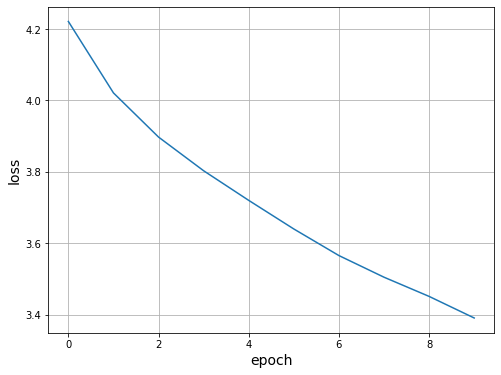

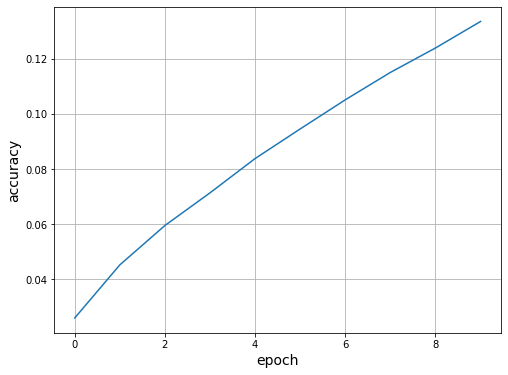

In [26]:
# TODO: Plot your training accuracies and training loss function vs epochs!
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('loss',fontsize=14)

plt.figure(num=None,figsize=(8, 6))
plt.plot(accuracy_sequence)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('accuracy',fontsize=14)

Is your model learning? Is the loss decreasing? Is it able to classifiy better after training?


### Evaluate Model

Evaluate the model performance on the test set. Compute the cross entropy loss and accuracy on the test set.

Note:  Please don't report false numbers for the accuracy as we will be reviewing these manually and if if there is a manipulation with the accuracy computation, you will get a 0 for the entire section.


In [33]:
def test_model(net, criterion, test_loader, metric):
  for i, (data, label) in enumerate (test_loader):
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)       
    data = data.reshape(-1, 3 * 224 * 224)
    with autograd.record(): 
      output = net(data)
      loss = criterion(output, label)
      predictions = ndarray.argmax(output.as_nd_ndarray(), axis=1)
      metric.update(preds=predictions, labels=label)     
      accuracy = metric.get()[1]  
    loss.backward()
    loss = ndarray.mean(loss.as_nd_ndarray()).asscalar()
  testing_accuracy = accuracy 
  testing_loss = loss 
  return testing_loss, testing_accuracy

metric = mx.metric.Accuracy() #TODO: Define an accuracy metric
lr_testing_loss, lr_testing_accuracy = test_model(net, criterion, test_loader, metric)

print("Logisitic Regression - the testing loss is ", str(lr_testing_loss))
print("Logisitic Regression - the testing accuracy is ", str(lr_testing_accuracy))

Logisitic Regression - the testing loss is  4.236562
Logisitic Regression - the testing accuracy is  0.08170914542728636


In [34]:
# Grader Cell : 8 Points
grader.grade('check_lr_test', (lr_testing_accuracy,lr_testing_loss))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Does the logistic regression fit well to the data? Think about whether this is underfitting or overfitting? Think about if we need more representational power or we need more regularization to make it better?

## 2.1.2 Feedforward Neural Networks (25 points)

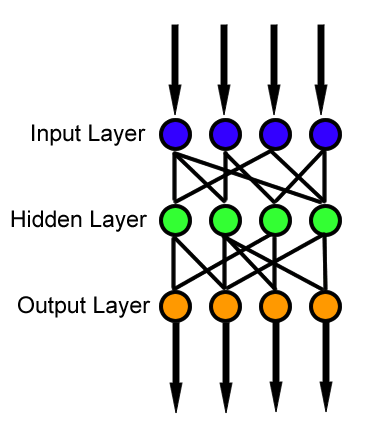

Since logistic regression isn't that great at fitting our classification problem, we need more representation power. We will now define a feedforward neural network


Complete the `create_ff_net` function below to define a feedforward neural network with at least 2 hidden layers. Note that the last layer must have the number of classes as the output size. You will also need to initialize the network, create a new trainer object with the parameters of the feedforward network. Use a ReLU activation function for the hidden layers. 


In [35]:
from mxnet import gluon, autograd, ndarray

def construct_ff_net():
  ff_net = mx.gluon.nn.Sequential()
  # TODO: Create a feedforward network, experiment with the number of hidden layers and
  # the number of sizes of the hidden layers
  with ff_net.name_scope(): #300 - 600
    ff_net.add(gluon.nn.Dense(512, activation="relu"))
    ff_net.add(gluon.nn.Dense(512, activation="relu"))
    ff_net.add(gluon.nn.Dense(67))
  return ff_net
ff_net  = construct_ff_net()

#TODO: Initialize the network
ff_net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

#TODO: Create a new trainer object for this network
trainer = mx.gluon.Trainer(ff_net.collect_params(), "adam", {'learning_rate': 0.0005})

Print the model summary for the fully connected network.

In [37]:
x = mx.sym.var('data')
sym = ff_net(x.as_np_ndarray())
mx.viz.print_summary(sym)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                                                  0                                           
________________________________________________________________________________________________________________________
sequential1_dense0_fwd(FullyConnected)                                      512         data                            
________________________________________________________________________________________________________________________
sequential1_dense0_relu_fwd(Activation)                                     0           sequential1_dense0_fwd          
________________________________________________________________________________________________________________________
sequential1_dense1_fwd(FullyConn

Now train this network using the train network function defined above. Create plots for the training accuracy and training loss vs the number of epochs.


Text(0, 0.5, 'accuracy')

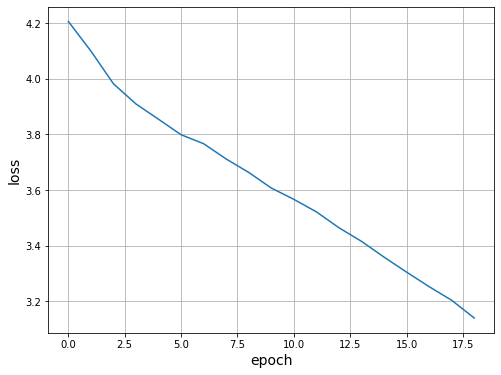

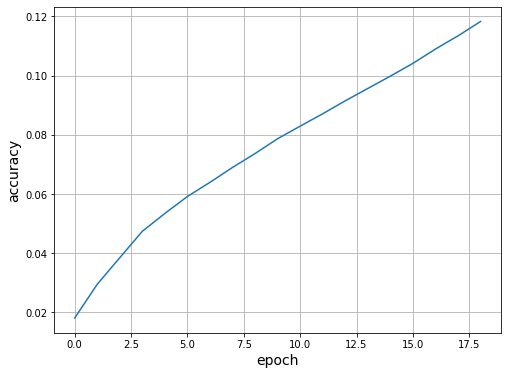

In [47]:
#TODO: plot curves
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('loss',fontsize=14)

plt.figure(num=None,figsize=(8, 6))
plt.plot(accuracy_sequence)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('accuracy',fontsize=14)

In [40]:
#TODO: Train the feedforward neural network on the training set using the train_network function
def train_network(net, train_loader, criterion, trainer, metric, epochs = 16):
    #TODO: Define your training loop here
    for e in range(epochs):
      cumulative_loss = mx.nd.zeros(1, ctx=ctx)
      training_sample = 0
      for i, (data, label) in enumerate (train_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)       
        data = data.reshape(-1, 3 * 224 * 224)
        with autograd.record(): 
          output = net(data)
          loss = criterion(output, label)
          metric.update(preds=output.as_nd_ndarray(), labels=label)     
          accuracy = metric.get()[1]  
        loss.backward()
        cumulative_loss += loss.as_nd_ndarray().sum()
        loss = cumulative_loss.asscalar()/training_sample
        training_sample += data.shape[0]
        trainer.step(data.shape[0])
      loss_sequence.append(loss)
      accuracy_sequence.append(accuracy)
      print(f"For echo {e}, accuracy = {accuracy}, loss = {loss}")
    final_training_accuracy = accuracy 
    final_training_loss = loss 
    return final_training_loss, final_training_accuracy

epochs = 16
loss_sequence = []
accuracy_sequence = []
metric = mx.metric.Accuracy()

ffn_training_loss, ffn_training_accuracy = train_network(ff_net, train_loader, criterion, trainer, metric, epochs) # TODO

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


For echo 0, accuracy = 0.018134230697326604, loss = 4.20538330078125
For echo 1, accuracy = 0.02953823144512993, loss = 4.099044708434693
For echo 2, accuracy = 0.03851187137782763, loss = 3.98152571809506
For echo 3, accuracy = 0.04743877360254253, loss = 3.90885514127994
For echo 4, accuracy = 0.0534679379323238, loss = 3.85400244433009
For echo 5, accuracy = 0.059201096778213995, loss = 3.79838297038735
For echo 6, accuracy = 0.06396389178217557, loss = 3.7661611591270585
For echo 7, accuracy = 0.06900822583660497, loss = 3.7111809096650448
For echo 8, accuracy = 0.07370017241021166, loss = 3.6630475621023577
For echo 9, accuracy = 0.07870630024303608, loss = 3.606908010151572
For echo 10, accuracy = 0.08295518278692704, loss = 3.566256768689184
For echo 11, accuracy = 0.08713466691593444, loss = 3.52142187792384
For echo 12, accuracy = 0.09151962264693617, loss = 3.4642429009169162
For echo 13, accuracy = 0.09567876505621879, loss = 3.4154315879958834
For echo 14, accuracy = 0.0998

In [41]:
grader.grade('check_ffn_train', (ffn_training_accuracy,ffn_training_loss))

Correct! You earned 10/10 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Once again, evaluate the model performance on the test set. Compute the cross entropy loss and accuracy on the test set

In [45]:
# TODO: Compute performance on the test set using the test_network function created before
def test_model(net, criterion, test_loader, metric):
  for i, (data, label) in enumerate (test_loader):
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)       
    data = data.reshape(-1, 3 * 224 * 224)
    with autograd.record(): 
      output = net(data)
      loss = criterion(output, label)
      predictions = ndarray.argmax(output.as_nd_ndarray(), axis=1)
      metric.update(preds=predictions, labels=label)     
      accuracy = metric.get()[1]  
    loss.backward()
    loss = ndarray.mean(loss.as_nd_ndarray()).asscalar()
  testing_accuracy = accuracy 
  testing_loss = loss 
  return testing_loss, testing_accuracy

metric = mx.metric.Accuracy() #TODO: Define an accuracy metric
ffn_testing_loss, ffn_testing_accuracy = test_model(ff_net, criterion, test_loader, metric)

In [46]:
grader.grade('check_ffn_test', (ffn_testing_accuracy,ffn_testing_loss))

Correct! You earned 10/10 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Does the feedforward network do better than logistic regression? Play around with the network architecture to see how it affects the performance on both the train and test data.

## 2.1.3 Convoluted Convolutional Neural Networks (30 points)
**So, what are CNNs?**

Convolutional Neural Networks are very similar to Feedforward Neural Networks from the previous section: they are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. The whole network still expresses a single differentiable score function: from the raw image pixels on one end to class scores at the other. 

So what changes? ConvNet architectures make the explicit assumption that the inputs are images, which allows us to encode certain properties into the architecture. These then make the forward function more efficient to implement and vastly reduce the amount of parameters in the network.

If you wanna know more about how CNNs function and see some cool visualizations, we would highly recommend [this](http://cs231n.github.io/convolutional-networks/) page


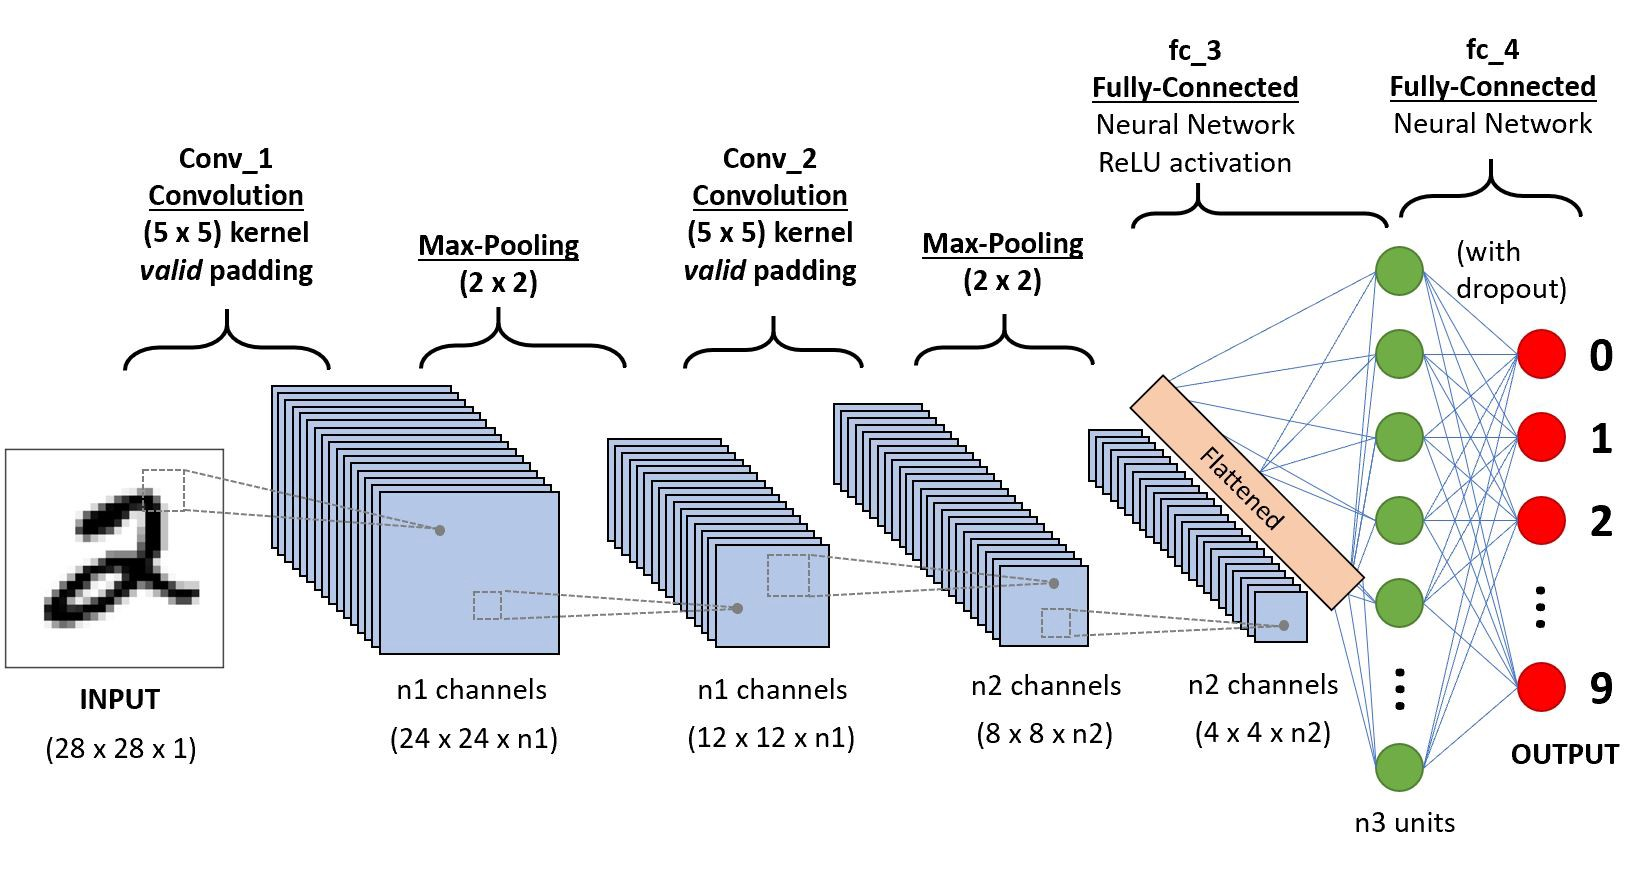


We will define the architecture for the CNN we will be using. The components of CNNs are: 


*   Convolutional Layers
*   Pooling Layers
*   Linear Layers
*   Activation Functions

Define a CNN model with Mxnet and Gluon with a convolutional layer followed by an activation function and a max pool, for one or more layers; then flatten the output from the convolutional layers and pass it through one or more fully connected or 'dense' layers and activation functions after all but the last layer. Note that the output shape from the last layer must be the same as the number of classes.

You can find some examples of this here: https://gluon.mxnet.io/chapter03_deep-neural-networks/mlp-gluon.html#Faster-modeling-with-gluon.nn.Sequential

In [48]:
import mxnet.ndarray as F
from mxnet.gluon import nn

class ConvNet(gluon.Block):
    def __init__(self, **kwargs):
        super(ConvNet, self).__init__(**kwargs)
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            # TODO: Define layers here
            self.conv1 = nn.Conv2D(20, kernel_size=(5,5))
            self.pool1 = nn.MaxPool2D(pool_size=(2,2), strides = (2,2))
            self.conv2 = nn.Conv2D(50, kernel_size=(5,5))
            self.pool2 = nn.MaxPool2D(pool_size=(2,2), strides = (2,2))
            self.conv3 = nn.Conv2D(50, kernel_size=(5,5))
            self.pool3 = nn.MaxPool2D(pool_size=(2,2), strides = (2,2))
            self.fc1 = nn.Dense(512)
            self.fc2 = nn.Dense(67)
    def forward(self, x):
        # TODO: Apply Conv and Pool layers
        # TODO: Reshape to flatten the tensor
        # TODO: Apply fully connected layers
        x = self.pool1(F.tanh(self.conv1(x)))
        x = self.pool2(F.tanh(self.conv2(x)))
        x = self.pool3(F.tanh(self.conv3(x)))
        x = x.reshape((0, -1))
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

Once again, we ask you to create a network, initialize it and create a trainer for it.

In [49]:
#TODO : Initialize network, initialize the criterion and the trainer
cnn = ConvNet()

cnn.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
trainer = gluon.Trainer(cnn.collect_params(), 'adam', {'learning_rate': 0.00015})
criterion = gluon.loss.SoftmaxCrossEntropyLoss()

In [50]:
#Grader Cell - Worth 10 points
grader.grade('check_cnn_model', (str(cnn.collect_params())))

Correct! You earned 10/10 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Write another function to train a convolutional neural network on the train data given the network, trainer and criterion. Train the CNN for 10-25 epochs. 

Plot the training loss and accuracy curves.

Note that there will be a slight difference from training a feedforward network, because here you will the image information in separate chanels as the input rather than a single flattened input.

Note also that you may have to experiment with the number and widths of the layers, until you get satisfactory performance.  To give a hint of what's possible, our classifier achieve an accuracy score of 0.94 on this part (i.e., with the training dataset).

In [57]:
from mxnet import gluon, autograd, ndarray


#TODO: Define a training function which trains the passed network for the given number of epochs using the provided optimizer and criterion
# The function should return the final training loss and the final training accuracy
def train_cnn(net, train_loader, criterion, trainer, metric, epochs = 10):
    #TODO: Define your training loop here
    for e in range(epochs):
      cumulative_loss = mx.nd.zeros(1, ctx=ctx)
      training_sample = 0
      for i, (data, label) in enumerate (train_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)       
        with autograd.record(): 
          output = net(data)
          loss = criterion(output, label)
          metric.update(preds=output.as_nd_ndarray(), labels=label)     
          accuracy = metric.get()[1]  
        loss.backward()
        cumulative_loss += loss.as_nd_ndarray().sum()
        loss = cumulative_loss.asscalar()/training_sample
        training_sample += data.shape[0]
        #trainer.step(data.shape[0])
      loss_sequence.append(loss)
      accuracy_sequence.append(accuracy)
      print(f"For echo {e}, accuracy = {accuracy}, loss = {loss}")
    final_training_accuracy = accuracy 
    final_training_loss = loss
    return final_training_loss, final_training_accuracy

    final_training_accuracy = None #TODO: Set this to final training accuracy
    final_training_loss = None #TODO: Set this to final testing accuracy
    return final_training_loss, final_training_accuracy

epochs = 10
loss_sequence = []
accuracy_sequence = []
metric = mx.metric.Accuracy()
cnn_training_loss, cnn_training_accuracy = train_cnn(net, train_loader, criterion, trainer, metric, epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


For echo 0, accuracy = 0.24677509814918677, loss = 3.310591829037238
For echo 1, accuracy = 0.24677509814918677, loss = 3.310591098077283
For echo 2, accuracy = 0.24677509814918677, loss = 3.310591829037238
For echo 3, accuracy = 0.24677509814918677, loss = 3.310591098077283
For echo 4, accuracy = 0.24677509814918677, loss = 3.3105921945172154
For echo 5, accuracy = 0.24677509814918677, loss = 3.310591098077283
For echo 6, accuracy = 0.24677509814918677, loss = 3.310591098077283
For echo 7, accuracy = 0.24677509814918677, loss = 3.310591098077283
For echo 8, accuracy = 0.24677509814918677, loss = 3.3105914635572606
For echo 9, accuracy = 0.24677509814918677, loss = 3.3105914635572606


Text(0, 0.5, 'accuracy')

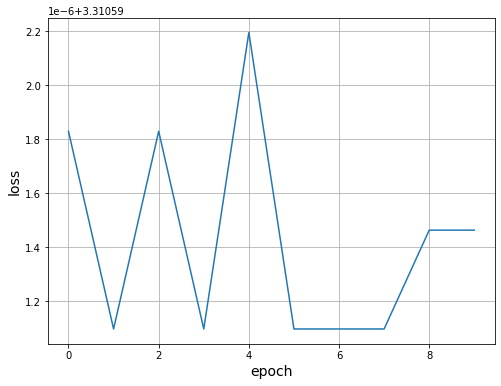

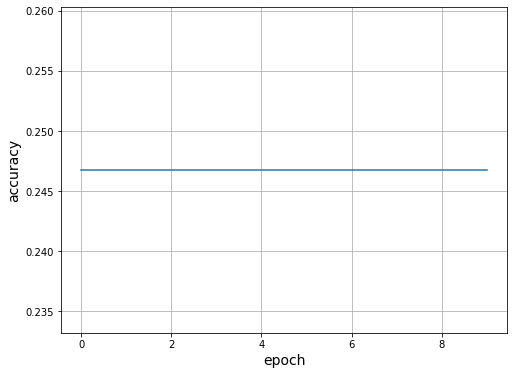

In [58]:
# TODO: don't forget to plot training loss + accuracy curves!
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('loss',fontsize=14)

plt.figure(num=None,figsize=(8, 6))
plt.plot(accuracy_sequence)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('accuracy',fontsize=14)

In [59]:
grader.grade('check_cnn_train', (cnn_training_accuracy, cnn_training_loss))

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Once again, evaluate the model performance on the test set. Compute the cross entropy loss and accuracy on the test set.

In [120]:
# TODO: Compute performance on the test set, you may need to write a new function modifying test_network without the flattening aspect
from mxnet import gluon, autograd, ndarray
npx.set_np()

def test_model(net, criterion, test_loader, metric):
  for i, (data, label) in enumerate (test_loader):
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)       
    with autograd.record(): 
      output = net(data.as_nd_ndarray())
      loss = criterion(output, label)
      metric.update(preds=output, labels=label)    
      accuracy = metric.get()[1]  
    loss.backward()
    loss = ndarray.mean(loss).asscalar()
  testing_loss = loss 
  testing_accuracy = accuracy 
  return testing_loss, testing_accuracy

metric = mx.metric.Accuracy()
cnn_testing_loss, cnn_testing_accuracy = test_model(cnn, criterion, test_loader, metric)


TypeError: ignored

In [106]:
#grader.grade('check_cnn_test', (cnn_testing_accuracy, cnn_testing_loss))
type(data)

mxnet.numpy.ndarray

How does the CNN perform? Does it out perform feedforward network?

Print out the number of learned parameters for the CNN and for the FFN. Does the CNN have more parameters? Think about how this links to performance and how CNN is so powerful?